**Preparação para análise de dados e ingestão de dados para GCP**

Olá!
Primeiramente, preciso trazer nosso dados para esse notebook, irei utilizar a lib pandas para isso, como o formato das tabelas estão em xls, precisei usar a engine xlrd para fazer a leitura, e logo converti para excel, e dividi as tabelas como itens individuais ao invés de manter em uma pasta de trabalho, achei melhor dividir antes de selecionar qual ferramente de dataviz iria usar para análise.

In [1]:
import pandas as pd

In [ ]:
pip install xlrd


In [55]:
import pandas as pd

# Local do arquivo original
file_path = r'C:\Users\vinyc\Desktop\Teste Lambda3\1\sample.xls'

# Lendo os DataFrames
orders_df = pd.read_excel(file_path, sheet_name='Orders', engine='xlrd')
people_df = pd.read_excel(file_path, sheet_name='People', engine='xlrd')
returns_df = pd.read_excel(file_path, sheet_name='Returns', engine='xlrd')

# Dicionário contendo os nomes e os DataFrames
dfs = {
    "orders": orders_df,
    "people": people_df,
    "returns": returns_df
}

# Salvando cada DataFrame em seu próprio arquivo Excel
for name, df in dfs.items():
    # Construindo o caminho para o arquivo Excel com base no caminho original do arquivo
    excel_output_path = file_path.replace("sample.xls", f"{name}.xlsx")
    
    with pd.ExcelWriter(excel_output_path, engine='openpyxl') as writer:
        df.to_excel(writer, sheet_name=name, index=False)
        print(f"DataFrame {name} salvo como {excel_output_path}")


DataFrame orders salvo como C:\Users\vinyc\Desktop\Teste Lambda3\1\orders.xlsx
DataFrame people salvo como C:\Users\vinyc\Desktop\Teste Lambda3\1\people.xlsx
DataFrame returns salvo como C:\Users\vinyc\Desktop\Teste Lambda3\1\returns.xlsx


**Procura de valores nulos**

Nesse momento, quis verificar se havia algum item vazio nos dataframes, para poder resolver, caso necessário, os dados vazio.

In [41]:
dataframes = {
    "orders": orders_df,
    "people": people_df,
    "returns": returns_df
}

for name, df in dataframes.items():
    print(f"Análise para {name.upper()}:")
    
    # Identificando valores nulos
    null_values = df.isnull().sum()
    print("Valores nulos:\n", null_values)
    
    # Identificando valores em branco
    blank_values = (df[df.select_dtypes(include=['object']) == ''].sum())
    print("\nValores em branco:\n", blank_values)
    
    # Calculando valores ausentes totais
    missing_values = null_values + blank_values
    print("\nValores ausentes totais:\n", missing_values)
    
    print("\n" + "-"*50 + "\n")


Análise para ORDERS:
Valores nulos:
 Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

Valores em branco:
 Row ID           0.0
Order ID           0
Order Date         0
Ship Date          0
Ship Mode          0
Customer ID        0
Customer Name      0
Segment            0
Country            0
City               0
State              0
Postal Code      0.0
Region             0
Product ID         0
Category           0
Sub-Category       0
Product Name       0
Sales            0.0
Quantity         0.0
Discount         0.0
Profit           0.0
dtype: object

Valores ausentes totais:
 Row ID           0.0
Order ID           0
Order 

**Conflitos com o GCP**

Apartir do entendimento que não haviam dados nulos, decidi usar o Looker para dataviz, e para facilitar o uso, vou subir os dados para o bigquery, assim facilitando o uso da ferramenta.
Por conhecimentos posteriores, já sabia que há um certo conflito da forma que o bigquery recebe itens como objetos, então, logo converti esses itens para str, assim evitando conflitos no upload.

In [45]:
for table_name, df in dataframes.items():
    print(f"Tipos de dados para {table_name}:")
    print(df.dtypes)
    print("-" * 50)

Tipos de dados para orders:
Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object
--------------------------------------------------
Tipos de dados para people:
Person    object
Region    object
dtype: object
--------------------------------------------------
Tipos de dados para returns:
Returned    object
Order ID    object
dtype: object
--------------------------------------------------


In [46]:
dataframes = {
    "orders": orders_df,
    "people": people_df,
    "returns": returns_df
}

for name, df in dataframes.items():
    # Identificando colunas do tipo 'object'
    object_cols = df.select_dtypes(include=['object']).columns
    
    # Convertendo essas colunas para 'string'
    for col in object_cols:
        df[col] = df[col].astype('string')

    # Verificando os tipos de dados após a conversão
    print(f"Tipos de dados para {name}:")
    print(df.dtypes)
    print("-" * 50)

Tipos de dados para orders:
Row ID             int64
Order ID          string
Order Date        string
Ship Date         string
Ship Mode         string
Customer ID       string
Customer Name     string
Segment           string
Country           string
City              string
State             string
Postal Code        int64
Region            string
Product ID        string
Category          string
Sub-Category      string
Product Name      string
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object
--------------------------------------------------
Tipos de dados para people:
Person    string
Region    string
dtype: object
--------------------------------------------------
Tipos de dados para returns:
Returned    string
Order ID    string
dtype: object
--------------------------------------------------


**Ingestão no Bigquery**

Após realizar a conversão, configurei o ambiente de upload para o gcp e montei meu datalake para análise.

In [ ]:
pip install pandas-gbq

In [43]:
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"C:\Users\vinyc\Desktop\Teste Lambda3\sublime-object-402619-81dc3d5b4124.json"


In [48]:
import pandas_gbq

project_id = "sublime-object-402619" 
dataset_id = "desafio_lambda3"  

dataframes = {
    "orders": orders_df,
    "people": people_df,
    "returns": returns_df
}

for table_name, df in dataframes.items():
    full_table_id = f"{dataset_id}.{table_name}"
    df.to_gbq(full_table_id, project_id=project_id, if_exists='replace')

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


**Dataviz**

Aqui irei postar algumas imagens de como está o datalake e as análises montadas, junto com meus comentários sobre.

In [3]:
from IPython.display import Image

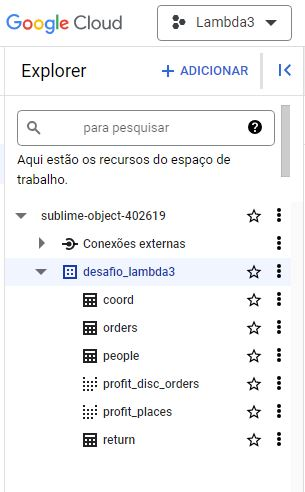

In [5]:
Image(filename= r'C:\Users\vinyc\Desktop\Teste Lambda3\datalake.jpg', width=250, height=300)

Após subir nossos dataframes no bigquery, temos essa formação. Para o dataviz, criei duas views profit_disc_orders e profit_places, ao qual utilizei os códigos abaixo em sql.

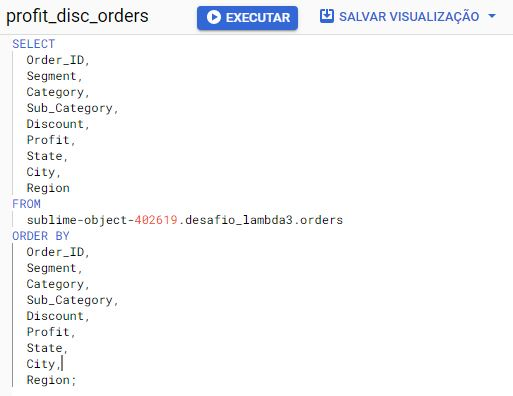

In [7]:
Image(filename= r'C:\Users\vinyc\Desktop\Teste Lambda3\profit_disc_orders.jpg', width=500, height=300)

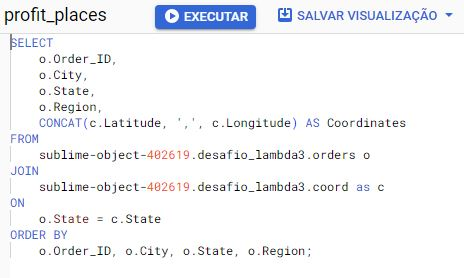

In [8]:
Image(filename= r'C:\Users\vinyc\Desktop\Teste Lambda3\profit_places.jpg', width=500, height=300)

Adicionei uma tabela de coordenadas, pois gostaria de usar gráficos geográficos na visualização

**Dataviz!**

Dentro do dataviz, montei três tabelas em um formato interativo, elas são:

1- Order Tracking: Aqui, mostro informações sobre os pedidos de forma geral, mostrando quantos pedidos foram feitos, pode ser visualizado em situações de estado, cidade ou região.

2- Profit and Discounts: Nesse painel, quis demonstrar o impacto dos descontos num profit total, utilizei a média dos descontos para avaliar. E podemos ver que existe uma clara divisão entre os altos profits, que seguem com descontos considerados baixos, enquanto os altos descontos, correspondem aos profits negativos.

3- Profit: Essa painel, compilei as informações sobre os profits em cada estado de forma acumulada junto com as médias de descontos praticadas, também, informações como médias de profit, max e min, e total, e utilizo mesmas métricas próximas para descontos, é possível verificar cada situação também por região, segmento e categoria.

Para acessar de forma completa, o link está público:
https://lookerstudio.google.com/reporting/0196c29d-8a06-4b56-8e08-0df613c31b33

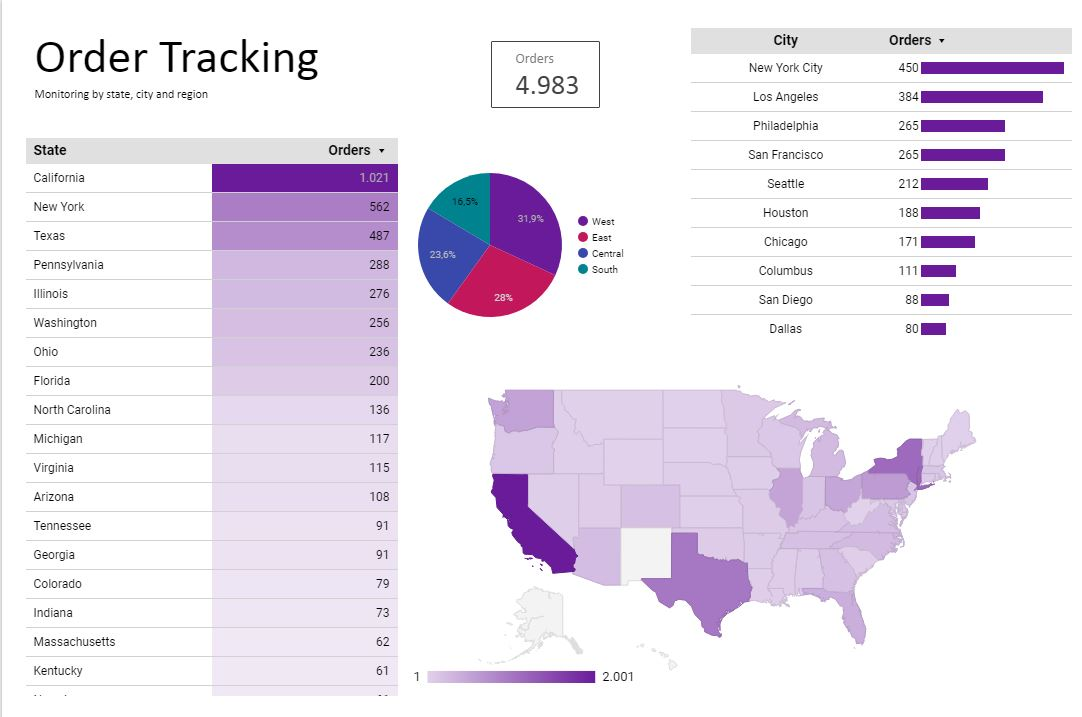

In [11]:
Image(filename= r'C:\Users\vinyc\Desktop\Teste Lambda3\order_tracking.jpg', width=600, height=400)

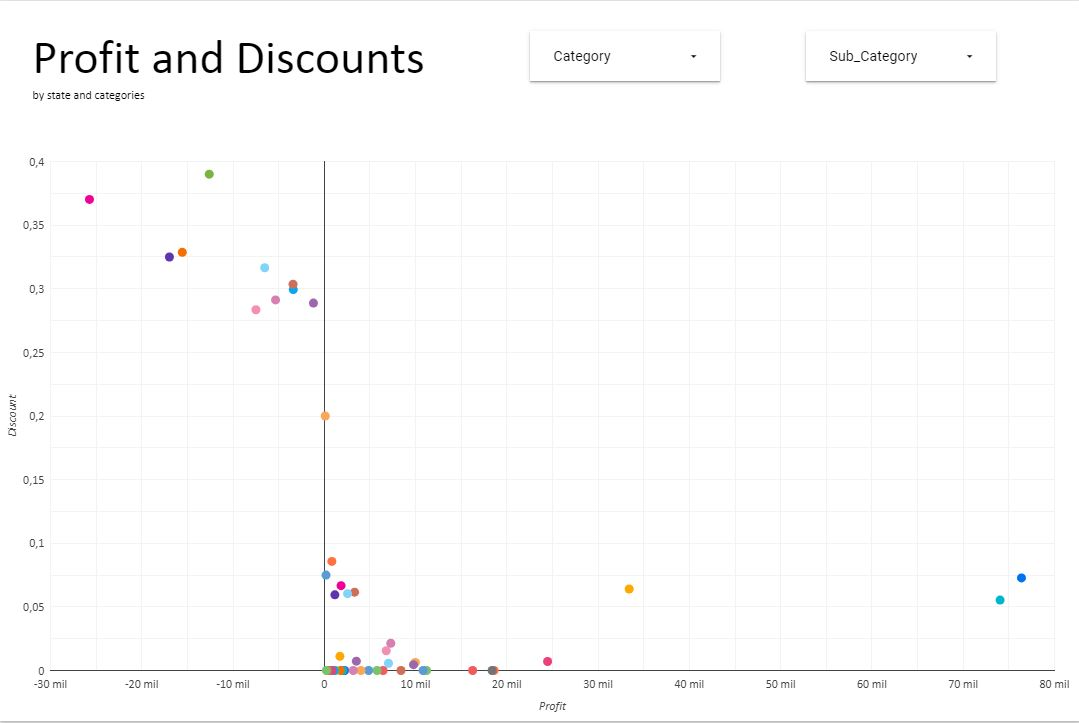

In [12]:
Image(filename= r'C:\Users\vinyc\Desktop\Teste Lambda3\profit_discounts.jpg', width=600, height=400)

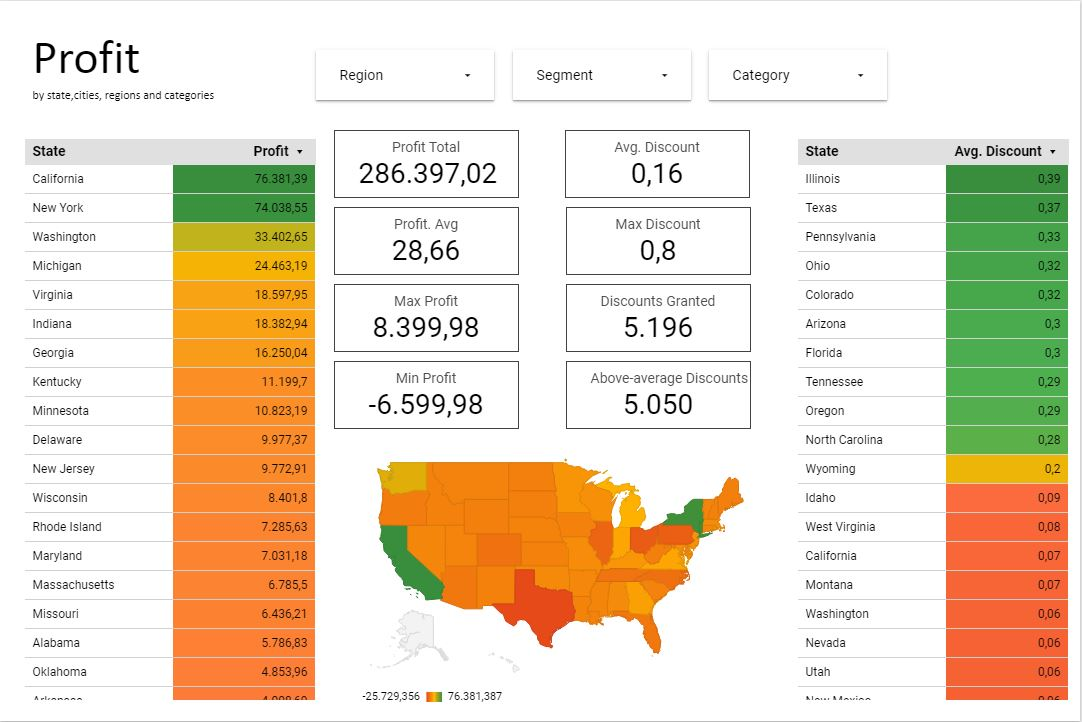

In [13]:
Image(filename= r'C:\Users\vinyc\Desktop\Teste Lambda3\profits.jpg', width=600, height=400)

---


**Manipulação de Json**

Agora, iremos visualizar o json e explorar os dados e transformar em um dataframe utilizavel, e também, upar no gcp!

In [14]:
df = pd.read_json(r'C:\Users\vinyc\Desktop\Teste Lambda3\2\data.json')


# explodir coluna itemlist no mesmo dataframe
expanded_items = df.explode('ItemList').reset_index(drop=True)
# normalizar dicionário
items_normalized = pd.json_normalize(expanded_items['ItemList'])

# Removendo a coluna original "ItemList" e concatenando com a coluna normalizada
df_expanded = pd.concat([expanded_items.drop(['ItemList'], axis=1).reset_index(drop=True), items_normalized], axis=1)


df_expanded.head()


,CreateDate,EmissionDate,Discount,NFeNumber,NFeID,ProductName,Value,Quantity
0,2021-05-24T20:21:34.79,2021-05-24T00:00:00,0,501,1,Rice,35.55,2
1,2021-05-24T20:21:34.79,2021-05-24T00:00:00,0,501,1,Flour,11.55,5
2,2021-05-24T20:21:34.79,2021-05-24T00:00:00,0,501,1,Bean,27.15,7
3,2021-05-24T20:21:34.79,2021-05-24T00:00:00,0,502,2,Tomate,12.25,10
4,2021-05-24T20:21:34.79,2021-05-24T00:00:00,0,502,2,Pasta,7.55,5


In [19]:
from pandas_gbq import to_gbq

project_id = "sublime-object-402619"
dataset_id = "desafio_lambda3"
table_id = "nf_lambda3"

# Construindo o full table ID
full_table_id = f"{project_id}.{dataset_id}.{table_id}"

# Enviar o dataframe para o BigQuery
to_gbq(df_expanded, full_table_id, project_id=project_id, if_exists='replace')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


---

**Fluxo de ingestão GCP**

O objetivo aqui é coletar dados de nota fiscal de uma API e armazená-los no BigQuery para análise posterior.

1- Coleta Automatizada com Cloud Scheduler e Cloud Functions: 
Cloud Scheduler é o nosso "cron job" na nuvem. Ele é configurado para ativar uma Cloud Function em intervalos predefinidos, como, por exemplo, a cada hora. Quando acionada pelo Scheduler, a Cloud Function executa um código que acessa a API fornecida, coleta os dados de nota fiscal e os envia para um tópico específico no Cloud Pub/Sub.

2- Buffer e Comunicação com Cloud Pub/Sub: 
O Cloud Pub/Sub serve como uma camada intermediária, agindo como um buffer temporário e garantindo que os dados sejam entregues ao próximo estágio de nosso pipeline de forma confiável e em ordem. Cada mensagem (neste caso, uma nota fiscal) é mantida no tópico até que seja processada pelo Cloud Dataflow.

3- Processamento e Transformação em Tempo Real com Cloud Dataflow:
Temos um job configurado no Cloud Dataflow que assina o tópico do Pub/Sub. Assim que os dados são publicados no tópico, o Dataflow os pega. O Dataflow processa e transforma esses dados conforme necessário, garantindo que estejam no formato e na estrutura corretos para serem armazenados no BigQuery.

4- Armazenamento BigQuery:
Uma vez processados e transformados, os dados são carregados no BigQuery. Esta plataforma serve como o repositório central de nossos dados. No BigQuery, podemos executar consultas SQL, criar painéis e extrair insights valiosos dos dados de nota fiscal.

5- Análise no Looker:
Após todos os processos, temos a ponta final, a visualização, iremos utilizar o looker, utizando os dados diretamente do bigquery podemos ter sempre as utilmas versões atualizadas e prontas da forma que prepararmos.

**Conclusão:**

Usamos ferramentas da GCP para criar um processo simples e eficaz de ingestão de dados. Desde a coleta até o armazenamento, cada etapa garante que os dados de nota fiscal sejam obtidos, tratados e guardados adequadamente para análises posteriores.